In [1]:
#source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

data = pd.read_csv('C:\\Users\\vinic\\Desktop\\R\\timeseries_models\\datasets\\pollution.csv', parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [3]:
data

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [4]:
# Dictionary:
#
#    No: row number
#    year: year of data in this row
#    month: month of data in this row
#    day: day of data in this row
#    hour: hour of data in this row
#    pm2.5: PM2.5 concentration
#    DEWP: Dew Point
#    TEMP: Temperature
#   PRES: Pressure
#    cbwd: Combined wind direction
#   Iws: Cumulated wind speed
#    Is: Cumulated hours of snow
#    Ir: Cumulated hours of rain


In [5]:
data.drop('No', axis=1, inplace=True)

In [6]:
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [7]:
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
data.index.name = 'date'
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
# summarize first 5 rows
print(data.head(5))
# save to file
data.to_csv('pollution_arrumado.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


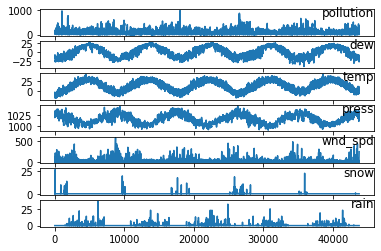

In [8]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution_arrumado.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

#obvias correlações. A ideia é, dados x1(t), x2(t), ... xn(t), descobrir o valor de y(t+1)

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    #input sequence(t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    #forecast sequence(t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-1))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg
    
	# input sequence (t-n, ... t-1)
	#for i in range(n_in, 0, -1):
#		cols.append(df.shift(i))
#		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
#	# forecast sequence (t, t+1, ... t+n)
#	for i in range(0, n_out):
#		cols.append(df.shift(-i))
#		if i == 0:
#			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#		else:
#			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
#	agg = concat(cols, axis=1)
#	agg.columns = names
	# drop rows with NaN values
#	if dropnan:
#		agg.dropna(inplace=True)
#	return agg

In [10]:
values = dataset.values

In [11]:
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [12]:
encoder = LabelEncoder()
values[:,4] =  encoder.fit_transform(values[:,4])
values = values.astype('float32')

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [14]:
#lag hours
n_hours = 3
n_features = 8

In [15]:
reframed = series_to_supervised(scaled, n_hours, 1)
pd.DataFrame(reframed) #pega as variaves xn em t-3, t-2, t-1, t

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.120724,0.470588,0.213115,0.600000,0.666667,0.020610,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43794,0.011066,0.205882,0.327869,0.745455,0.333333,0.349825,0.000000,0.0,0.008048,0.250000,...,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43795,0.008048,0.250000,0.311475,0.745455,0.333333,0.365103,0.000000,0.0,0.009054,0.264706,...,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43796,0.009054,0.264706,0.295082,0.763638,0.333333,0.377322,0.000000,0.0,0.010060,0.264706,...,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43797,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,...,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [16]:
values = reframed.values
n_train_hours = 365*24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [17]:
n_obs = n_hours * n_features
train_X, train_Y = train[:, :n_obs], train[:, -n_features]
test_X, test_Y = test[:, :n_obs], test[:, -n_features]

In [18]:
train_Y #var1 é o y

array([0.13883299, 0.10965794, 0.1056338 , ..., 0.03118712, 0.02012072,
       0.01911469], dtype=float32)

In [19]:
#resahpe pra ser 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [20]:
train_X.shape

(8760, 3, 8)

In [21]:
model = Sequential()

In [22]:
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [23]:
history = model.fit(train_X, train_Y, epochs = 50, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 8s - loss: 0.0550 - val_loss: 0.0540
Epoch 2/50
122/122 - 6s - loss: 0.0323 - val_loss: 0.0507
Epoch 3/50
122/122 - 6s - loss: 0.0278 - val_loss: 0.0309
Epoch 4/50
122/122 - 6s - loss: 0.0269 - val_loss: 0.0286
Epoch 5/50
122/122 - 6s - loss: 0.0270 - val_loss: 0.0285
Epoch 6/50
122/122 - 6s - loss: 0.0269 - val_loss: 0.0289
Epoch 7/50
122/122 - 6s - loss: 0.0264 - val_loss: 0.0293
Epoch 8/50
122/122 - 6s - loss: 0.0259 - val_loss: 0.0283
Epoch 9/50
122/122 - 6s - loss: 0.0256 - val_loss: 0.0277
Epoch 10/50
122/122 - 6s - loss: 0.0252 - val_loss: 0.0277
Epoch 11/50
122/122 - 6s - loss: 0.0250 - val_loss: 0.0270
Epoch 12/50
122/122 - 6s - loss: 0.0246 - val_loss: 0.0276
Epoch 13/50
122/122 - 6s - loss: 0.0243 - val_loss: 0.0267
Epoch 14/50
122/122 - 6s - loss: 0.0241 - val_loss: 0.0274
Epoch 15/50
122/122 - 6s - loss: 0.0239 - val_loss: 0.0266
Epoch 16/50
122/122 - 6s - loss: 0.0236 - val_loss: 0.0264
Epoch 17/50
122/122 - 6s - loss: 0.0234 - val_loss: 0.0256
Epoch 

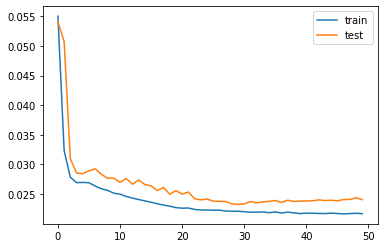

In [24]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [25]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [26]:
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat

array([14.52707 , 13.251333, 12.297539, ...,  5.345779,  9.338408,
        9.038858], dtype=float32)

In [27]:
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_Y, test_X[:, -7:]), axis=1)
inv_y = inv_y[:,0]
inv_y

array([0.01810865, 0.01710262, 0.01408451, ..., 0.01006036, 0.00804829,
       0.01207243], dtype=float32)

In [28]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE do teste: ", rmse)

RMSE do teste:  136.8109938816139


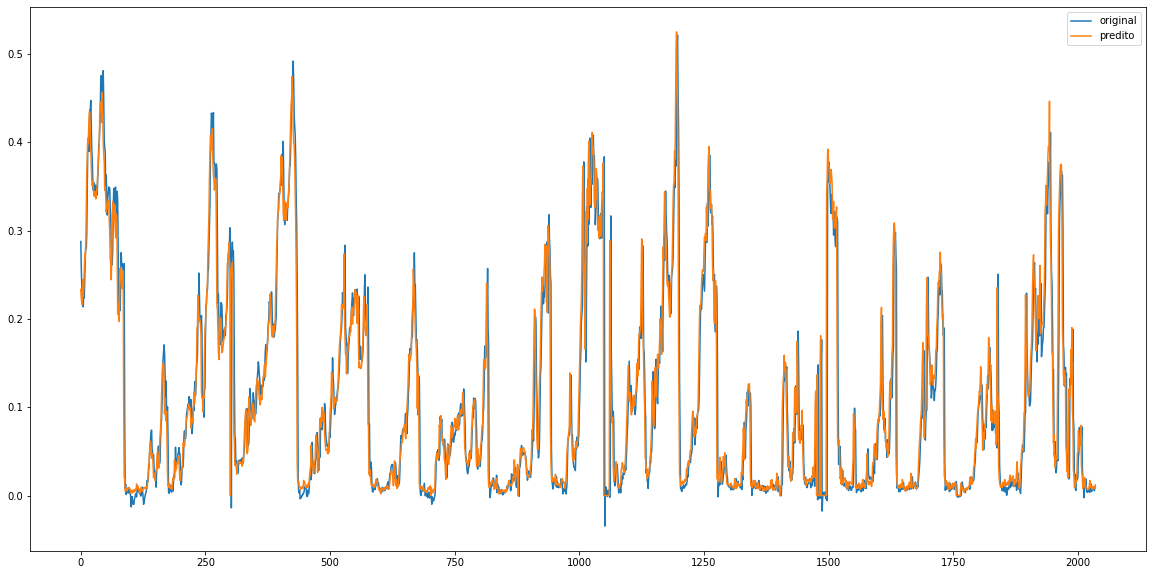

In [29]:
pyplot.figure(figsize=(20,10))
pyplot.plot(yhat[33000:], label='original')
pyplot.plot(test_Y[33000:], label='predito')
pyplot.legend(loc = 'best')

In [31]:
scaler.inverse_transform(test_X)

ValueError: operands could not be broadcast together with shapes (35036,24) (8,) (35036,24) 